In [86]:
import numpy as np
import pandas as pd
import re
import json 
import sys
import codecs 
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import operator
import pickle 
import nltk.data
from sklearn.model_selection import train_test_split
import math
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#open raw data in json format 
with open("data_raw.json") as f:
    data = json.loads(f.read())

# 1 Cleaning and vectorization process


## 1.1 Cleaning data

In [3]:
m = Mystem() # from Yandex stopwords library
stopWords = set(stopwords.words("russian")) # set our language to russian

In [4]:
#add new 'Vk popular' stop words by hand (195)
badwords = [
u'я', u'а', u'да', u'но', u'тебе', u'мне', u'ты', u'и', u'у', u'на', u'ща', u'ага',
u'так', u'там', u'какие', u'который', u'какая', u'туда', u'давай', u'короче', u'кажется', u'вообще',
u'ну', u'не', u'чет', u'неа', u'свои', u'наше', u'хотя', u'такое', u'например', u'кароч', u'как-то',
u'нам', u'хм', u'всем', u'нет', u'да', u'оно', u'своем', u'про', u'вы', u'м', u'тд',
u'вся', u'кто-то', u'что-то', u'вам', u'это', u'эта', u'эти', u'этот', u'прям', u'либо', u'как', u'мы',
u'просто', u'блин', u'очень', u'самые', u'твоем', u'ваша', u'кстати', u'вроде', u'типа', u'пока', u'ок',u'в'
,u'б',u'г',u'д',u'е',u'ж',u'з',u'й',u'к',u'л',u'ф',u'н',u'о',u'п',u'р',u'с',u'т',u'ч',u'ц',u'ч',u'ш',u'щ',u'ь'
,u'ъ',u'ы',u'э','ю']

for words in badwords:
    stopWords.add(words)

In [5]:
# lemmatization of words
def lemma(data):
    lemmas = m.lemmatize(data)
    return ''.join(lemmas)

In [6]:
# deletes all stopwords
def stop_remove(data):
    for x in stopWords:
        if x in data:
            for item in range(data.count(x)):
                data.remove(x)
    return data            

In [7]:
# all cleaning processes 
def cleansing(data):
    cleaned_data = re.sub("[^а-яА-ЯЁё]"," ", data) #non-cyrillic letters
    cleaned_data = lemma(cleaned_data) # lemmatization
    cleaned_data = cleaned_data.lower().split() # split our sentences to words and set it to lowercase
    cleaned_data = stop_remove(cleaned_data) # remove stop words
    return cleaned_data

In [9]:
#cleaning
for i in range (0,len(data)):
    data[i]["text"] = cleansing(data[i]["text"])

In [10]:
# deleting duplicates 
new_list = list()
cnt = 0
for i in data:
    if (i not in new_list):
        new_list.append(i)
    else:
        cnt+=1
print (cnt)

#deleting duplicates with the same text but with different sentiment
new_list2 = list()
cnt = 0
for i in new_list:
    check = False
    for j in new_list:
        if (i["text"] == j["text"]) and ( i["manual_sentiment"] != j["manual_sentiment"] ):
            check = True
            cnt+=1
    if check == False:
        new_list2.append(i)
print(cnt)
new_list.clear()

46596
20640


In [35]:
# divide our data into text and sentiment (where positive = 1, neutral = 0, negative = -1)
text = []
sentiment = []
for item in data:
    text.append(item['text'])
    if item['manual_sentiment'] == 'neutral':
        sentiment.append(0)
    elif item['manual_sentiment'] == 'positive':
        sentiment.append(1)
    else:
        sentiment.append(-1)

## 1.2 Vectorization with averaging 

In [114]:
num_features = 50 # dimension
min_word_count = 40 # minimum word count
num_workers = 4 # n of threads 
context = 10 # context window size
downsampling = 1e-3

from gensim.models import word2vec
model = word2vec.Word2Vec(text,workers=num_workers,size=num_features,\
                          min_count=min_word_count,window=context,
                          sample=downsampling)

In [115]:
#for memory-efficency
model.init_sims(replace = True)

In [116]:
model_name = "Russian_word2vec"

In [117]:
model.save(model_name)

In [118]:
# to be sure that our model works
model.most_similar('казахстан')

[('международный', 0.6190066933631897),
 ('снг', 0.6153033971786499),
 ('казахстанский', 0.6145889759063721),
 ('страна', 0.6022635102272034),
 ('всемирный', 0.5864023566246033),
 ('армения', 0.5746820569038391),
 ('национальный', 0.5630109906196594),
 ('оэср', 0.5443229675292969),
 ('стратегический', 0.5441406965255737),
 ('беларусь', 0.5316131711006165)]

In [119]:
#function to average all of the word vectors in a given paragraph
def makeFeatureVec(words,model,num_features):
    featureVec = np.zeros((num_features,),dtype='float32')
    n = 0
    index2word_set = set(model.wv.index2word)
    
    for word in words:
        if word in index2word_set:
            n+=1
            featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,n)
    return featureVec

In [120]:
# Calculate the average feature vector for each one and return a 2d np array
def getAverageVec(posts, model, num_features):
    cnt = 0
    reviewFeatureVecs = np.zeros((len(posts),num_features),dtype='float32')
    
    for sentence in posts:
        reviewFeatureVecs[cnt] = makeFeatureVec(sentence,model,num_features)
        cnt+=1
    return reviewFeatureVecs    

In [121]:
# make processed data
DataVecs = getAverageVec(text,model,num_features)

/home/danit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Firstly, we have to check that our data contains NAN, strings and other non-numeric elements

In [125]:
np.isnan(DataVecs).any()

True

Then we check how many nan elements is in our dataset

In [126]:
np.count_nonzero(np.isnan(DataVecs))

1000

With built-in function "nan_to_num" replace all nan values to zero

In [127]:
DataVecs = np.nan_to_num(DataVecs)

# Building and Investigating which model is the best

Just to be sure that everything is ok

In [128]:
np.isnan(DataVecs).any()

False

In [129]:
#divide our data into training_set = 0.8 and testing_set = 20
X_train, X_test, y_train, y_test = train_test_split(DataVecs, sentiment, test_size=0.2,random_state = 42)

## Primitive model building

In [68]:
forest = RandomForestClassifier(n_estimators=100)

In [82]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [83]:
predicted = forest.predict(X_test)
print(forest.score(X_test, y_test))
print(metrics.classification_report(predicted,y_test))

0.816625764965
             precision    recall  f1-score   support

         -1       0.62      0.80      0.70      1995
          0       0.86      0.82      0.84     18364
          1       0.80      0.82      0.81     11832

avg / total       0.82      0.82      0.82     32191



# Brute Force of parameters

Number of trees

In [89]:
n_estimators = [200,350,400,500,700]
results = []
for trees in n_estimators:
    forest = RandomForestClassifier(n_estimators=trees,random_state=42)
    forest.fit(X_train,y_train)
    print("Trees ",trees)
    print("Score", forest.score(X_test,y_test))
    results.append(forest.score(X_test,y_test))  
pd.Series(results,n_estimators).plot()  

Trees  200
Score 0.816128731633
Trees  350
Score 0.817215992047
Trees  400
Score 0.81780621913
Trees  500
Score 0.818396446212
Trees  700
Score 0.818241123295


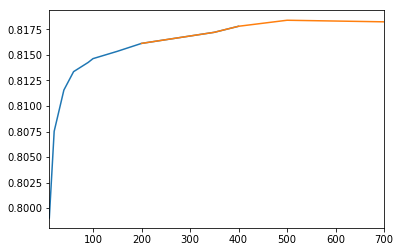

In [90]:
plt.show()

In [91]:
max_features = ["sqrt", "log2"]
results = []

for feature in max_features:
    forest = RandomForestClassifier(n_estimators=500, max_features = feature, random_state =42)
    forest.fit(X_train,y_train)
    print("Feature", feature)
    print("Score", forest.score(X_test,y_test))
    results.append(forest.score(X_test,y_test))
pd.Series(results,max_features).plot(kind='bar')    

Feature sqrt
Score 0.818396446212
Feature log2
Score 0.816905346215


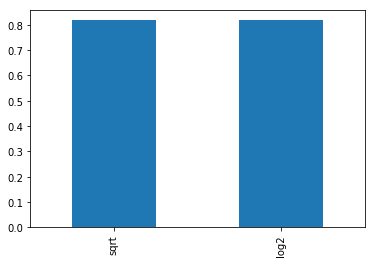

In [92]:
plt.show()

In [95]:
max_depth = [1,2,5,10,15,20,30,50,80]
results = []

for depth in max_depth:
    forest = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_depth=depth, random_state = 42)
    forest.fit(X_train,y_train)
    print("Depth", depth)
    print("Score", forest.score(X_test, y_test))
    results.append(forest.score(X_test, y_test))
pd.Series(results,max_depth).plot()    

Depth 1
Score 0.587710850859
Depth 2
Score 0.662079463204
Depth 5
Score 0.6958777298
Depth 10
Score 0.752632723432
Depth 15
Score 0.806032742071
Depth 20
Score 0.8161908608
Depth 30
Score 0.818116864962
Depth 50
Score 0.818769221211
Depth 80
Score 0.818396446212


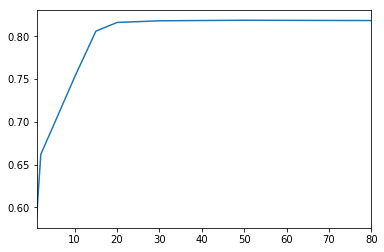

In [96]:
plt.show()

In [98]:
min_samples_leaf = [1,2,3,4,5]
results = []
for leaf in min_samples_leaf:
    forest = RandomForestClassifier(n_estimators=500,max_features="sqrt",max_depth=50, \
                                   min_samples_leaf=leaf,random_state=42)
    forest.fit(X_train,y_train)
    print("Leaf(s)",leaf)
    print("Score",forest.score(X_test,y_test))
    results.append(forest.score(X_test,y_test))
pd.Series(results,min_samples_leaf).plot() 

Leaf(s) 1
Score 0.818769221211
Leaf(s) 2
Score 0.818551769128
Leaf(s) 3
Score 0.815631698301
Leaf(s) 4
Score 0.813767823305
Leaf(s) 5
Score 0.813301854556


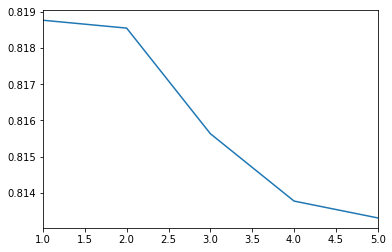

In [99]:
plt.show()

### Final model with tuned parameters

#### Train data with 80 % of data and test with 20%

In [131]:
forest = RandomForestClassifier(n_estimators = 500, max_features = "sqrt", max_depth = 50, \
                               min_samples_leaf =1, random_state = 42)

In [134]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [135]:
predicted = forest.predict(X_test)

In [136]:
print("Accuracy")
print(forest.score(X_test,y_test))
print("Metrics")
print(metrics.classification_report(predicted,y_test))

Accuracy
0.817992606629
Metrics
             precision    recall  f1-score   support

         -1       0.61      0.80      0.70      1977
          0       0.86      0.82      0.84     18410
          1       0.80      0.82      0.81     11804

avg / total       0.82      0.82      0.82     32191



#### Train with all data provided and test it from another source

In [105]:
with open ("data_test.json") as file:
    test_set = json.loads(file.read())

Clean our test data as train data 

In [110]:
for i in range(0, len(test_set)):
    test_set[i]['text'] = cleansing(test_set[i]['text'])

In [111]:
# deleting duplicates 
new_list = list()
cnt = 0
for i in test_set:
    if (i not in new_list):
        new_list.append(i)
    else:
        cnt+=1
print (cnt)

#deleting duplicates with the same text but with different sentiment
new_list2 = list()
cnt = 0
for i in new_list:
    check = False
    for j in new_list:
        if (i["text"] == j["text"]) and ( i["manual_sentiment"] != j["manual_sentiment"] ):
            check = True
            cnt+=1
    if check == False:
        new_list2.append(i)
print(cnt)
new_list.clear()

4623
1416


In [112]:
test_text = []
test_sentiment = []
for item in test_set:
    test_text.append(item["text"])
    if item['manual_sentiment'] == 'neutral':
        test_sentiment.append(0)
    elif item['manual_sentiment'] == 'positive':
        test_sentiment.append(1)
    else:
        test_sentiment.append(-1)

In [130]:
test = getAverageVec(test_text, model, num_features)

#### Final model

In [137]:
Final_RandomForest_model = RandomForestClassifier(n_estimators = 500, max_features = "sqrt", max_depth = 50, \
                               min_samples_leaf =1, random_state = 42)

In [138]:
Final_RandomForest_model.fit(DataVecs,sentiment)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [139]:
predicted = Final_RandomForest_model.predict(test)

In [140]:
print("Accuracy")
print(Final_RandomForest_model.score(test,test_sentiment))
print("Metrics")
print(metrics.classification_report(predicted,test_sentiment))

Accuracy
0.757397378542
Metrics
             precision    recall  f1-score   support

         -1       0.11      0.57      0.19       218
          0       0.90      0.79      0.84     10372
          1       0.52      0.62      0.57      2151

avg / total       0.82      0.76      0.78     12741



##### In conclusion, Random Forest model doesn't shows us good results. Only for texts with neutral sentiment, it shows good precision and recall value, while for negative it is not enough for our final solution. In future work I have to make cross-validation to detect is my model is overfitted or not, and try to tune my model with other parameters.